<a href="https://colab.research.google.com/github/yiran597/statistics_analysis/blob/main/%E6%83%85%E6%84%9F%E5%88%86%E6%9E%90%E6%A8%A1%E5%9E%8B2_%E6%9E%81%E6%AD%A3%E9%9D%A2%E8%AF%84%E4%BB%B7%E6%95%B0%E6%8D%AE%E9%9B%86%26%E5%85%B3%E9%94%AE%E8%AF%8D%E6%8F%90%E5%8F%96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Load function, Update Environment
import sys
!{sys.executable} -m pip install numpy
import numpy as np
!{sys.executable} -m pip install sklearn
from sklearn import metrics
!{sys.executable} -m pip install pandas
import pandas as pd
!{sys.executable} -m pip install nltk
import nltk
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from pprint import pprint
!{sys.executable} -m pip install pyLDAvis #visualizing LDA
import pyLDAvis
import pyLDAvis.lda_model

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 21.8 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Data Review & Audit:
import pandas as pd
comments = pd.read_csv("/content/drive/MyDrive/lilysilk/Data/translated_comments_emoji (1).csv")

In [5]:
comments['like_count'] = pd.to_numeric(comments['like_count'], errors='coerce')  # 如果无法转换，会变成 NaN
comments['likes'] = pd.to_numeric(comments['likes'], errors='coerce')  # 同样的处理
comments['total_likes'] = comments.groupby('publish_number')['like_count'].transform('sum') + comments['likes']
comments['representative_comment_likes'] = comments['like_count'] + comments['likes']

## Data Preprocessing

In [6]:
## Dropping variables as it will not play any role in text mining
reviews_of_comments = comments.drop(['publish_number'], axis=1).drop(['publish_url'], axis=1).drop(['video_id'], axis=1).drop(['text_display'], axis=1).drop(['like_count'], axis=1).drop(['published_at'], axis=1).drop(['likes'], axis=1).drop(['translated_text'], axis=1).drop(['emoji_column'], axis=1).drop(['total_likes'], axis=1)
reviews_of_comments.head()

,text_column,representative_comment_likes
0,"Beautiful haul, Irene. The purple top is so pr...",77.0
1,"Beautiful pieces you got, love Lilysilk, can\'...",78.0
2,Congrats on your haul Irene. Lily silk packagi...,77.0
3,Congratulations Irene the calvi card holder is...,77.0
4,Fab video. I love the calvi I use it load I ha...,77.0


In [7]:
# 将所有值转换为字符串类型，并将 NaN 替换为空字符串
reviews_of_comments['text_column'] = reviews_of_comments['text_column'].fillna('').astype(str)

In [8]:
## Deal with upper and lowercases
def text_lowercase(text):
    return text.lower()

reviews_of_comments['Reviews_clean']=reviews_of_comments['text_column'].apply(text_lowercase)

In [9]:
## Remove punctuations
import string
string.punctuation

def remove_punct(text):
    text_nonpunc="".join([char for char in text if char not in string.punctuation])
    return text_nonpunc

reviews_of_comments['Reviews_clean']=reviews_of_comments['Reviews_clean'].apply(remove_punct)

In [10]:
## Remove Whitespaces
def remove_whitespaces(text):
    return " ".join(text.split())
reviews_of_comments['Reviews_clean']=reviews_of_comments['Reviews_clean'].apply(lambda x:remove_whitespaces(x))

### Data Tokenization
- stopwords

In [11]:
import re

def tokenize(text):
    tokens = re.split('\W+', text)
    return tokens

reviews_of_comments['Reviews_clean'] = reviews_of_comments['Reviews_clean'].apply(lambda x: tokenize(x))

<>:4: DeprecationWarning: invalid escape sequence '\W'
<>:4: DeprecationWarning: invalid escape sequence '\W'
<ipython-input-11-26c86a74c59b>:4: DeprecationWarning: invalid escape sequence '\W'
  tokens = re.split('\W+', text)


In [12]:
## Remove stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')

def remove_stopwords(tokenized_list):
    filtered_text=[word for word in tokenized_list if word not in stop]
    return filtered_text

reviews_of_comments['Reviews_clean']=reviews_of_comments['Reviews_clean'].apply(lambda x:remove_stopwords(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Lemmatization

In [13]:
import nltk
nltk.download('wordnet')
wn=nltk.stem.WordNetLemmatizer()

def lemmatizing(text):
    lemma=[wn.lemmatize(word) for word in text]
    return lemma
reviews_of_comments['Reviews_clean']=reviews_of_comments['Reviews_clean'].apply(lemmatizing)

[nltk_data] Downloading package wordnet to /root/nltk_data...


### Supervised Learning for most frequent words

In [14]:
word_count={}

for sentence in reviews_of_comments['Reviews_clean']:
    for word in sentence:
        if word not in word_count:
            word_count[word]=1
        else:
            word_count[word]+=1

## Converting word_count into the dataframe
word_frequency = pd.DataFrame(word_count.items(), columns=['word','word_count'])
word_frequency = word_frequency.sort_values('word_count', ascending=False).reset_index(drop=True)
word_frequency.head()

,word,word_count
0,love,2856
1,look,1550
2,video,1491
3,like,1177
4,beautiful,1094


### Sentiment Analysis

In [15]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [18]:
import nltk
nltk.download('vader_lexicon')

analyser = SentimentIntensityAnalyzer()

def sentiment_pos(sentence):
  sent = analyser.polarity_scores(sentence)
  return sent['pos']

def sentiment_neg(sentence):
  sent = analyser.polarity_scores(sentence)
  return sent['neg']

def sentiment_neu(sentence):
  sent = analyser.polarity_scores(sentence)
  return sent['neu']

##comp (compound): A normalized score that combines the other three scores into a single value to indicate overall sentiment (positive, negative, or neutral).
def sentiment_comp(sentence):
  sent = analyser.polarity_scores(sentence)
  return sent['comp']

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [19]:
word_frequency['positive']=word_frequency['word'].apply(sentiment_pos)
word_frequency['negative']=word_frequency['word'].apply(sentiment_neg)

In [20]:
# Key negative words
words_negatives = word_frequency.loc[word_frequency.negative>0]['word']
words_negatives

,word
147,sorry
225,hard
258,bad
346,cut
386,worn
...,...
13048,violent
13072,evil
13073,criminal
13155,stubborn


visualization of negative words

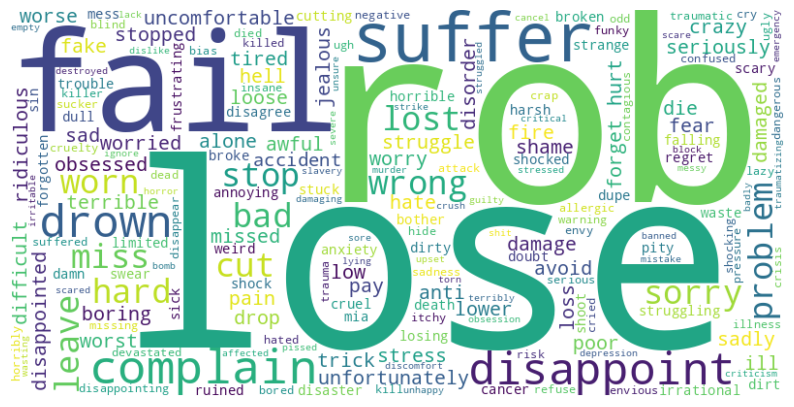

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

negative_words = " ".join(words_negatives)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_words)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

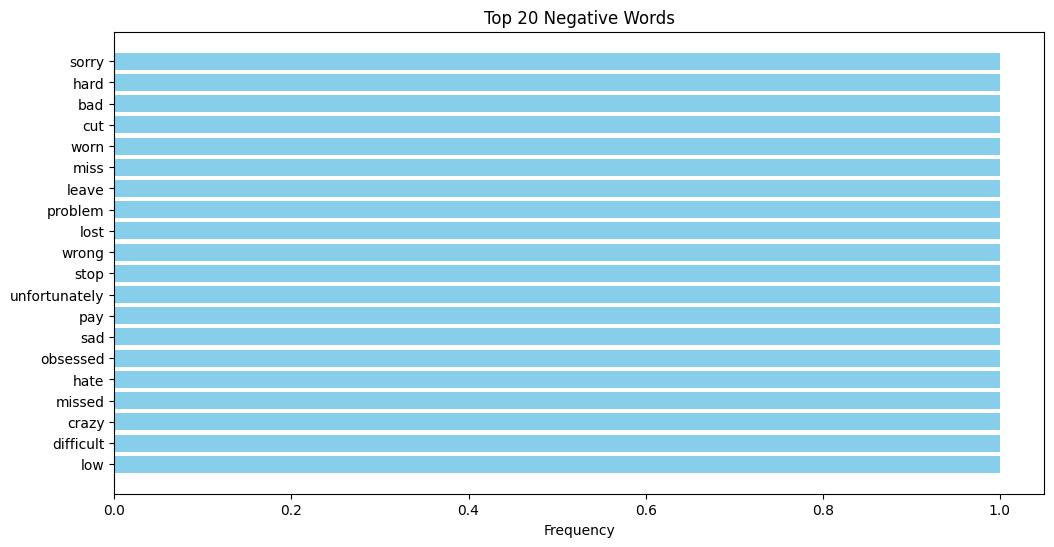

In [24]:
import matplotlib.pyplot as plt

word_frequencies = word_frequency.loc[word_frequency['negative'] > 0, ['word', 'negative']]

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.barh(word_frequencies['word'].head(20), word_frequencies['negative'].head(20), color='skyblue')
plt.xlabel('Frequency')
plt.title('Top 20 Negative Words')
plt.gca().invert_yaxis()  # To display the highest frequency at the top
plt.show()

In [21]:
# Key positive words
words_positives = word_frequency.loc[word_frequency.positive>0]['word']
words_positives

,word
0,love
3,like
4,beautiful
5,great
9,thank
...,...
13153,truthful
13157,thoughtfulness
13177,fortunate
13220,boosting


visualization of positive words

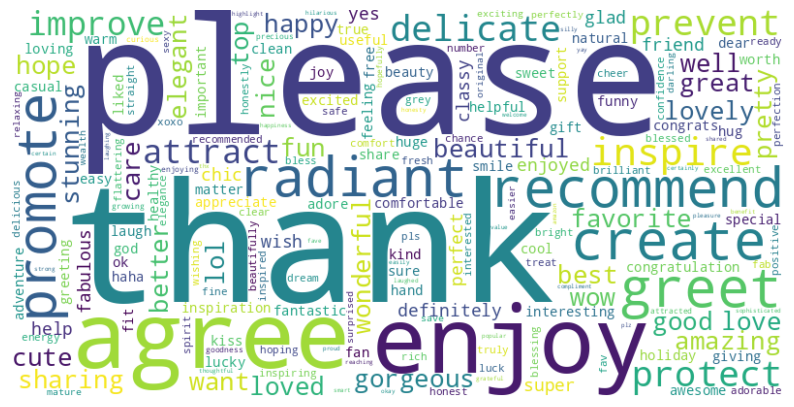

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

positive_words = " ".join(words_positives)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_words)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

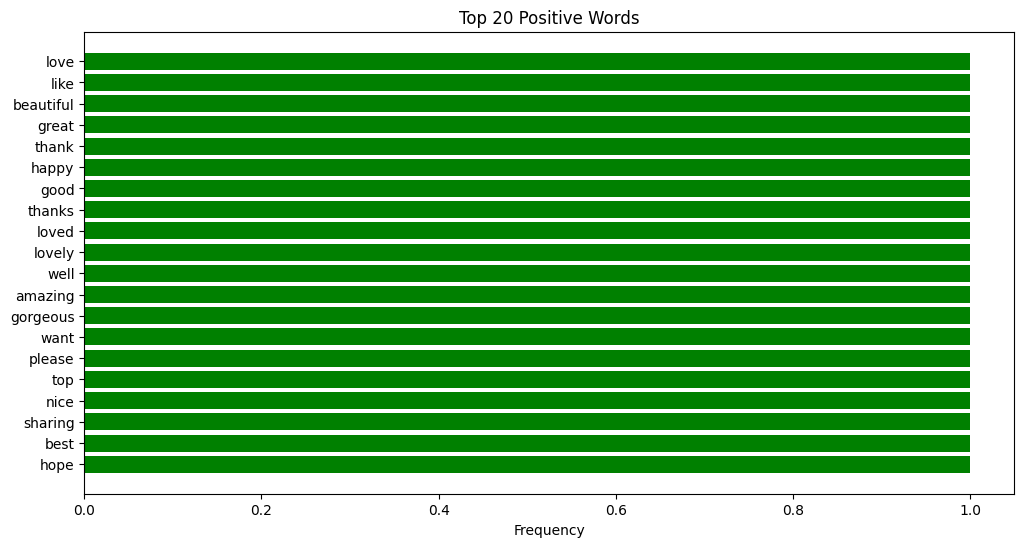

In [26]:
import matplotlib.pyplot as plt

word_frequencies2 = word_frequency.loc[word_frequency['positive'] > 0, ['word', 'positive']]

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.barh(word_frequencies2['word'].head(20), word_frequencies2['positive'].head(20), color='green')
plt.xlabel('Frequency')
plt.title('Top 20 Positive Words')
plt.gca().invert_yaxis()  # To display the highest frequency at the top
plt.show()

In [30]:
reviews_of_comments['positive'] = reviews_of_comments['text_column'].apply(sentiment_pos)
reviews_of_comments['negative'] = reviews_of_comments['text_column'].apply(sentiment_neg)
reviews_of_comments['neutral'] = reviews_of_comments['text_column'].apply(sentiment_neu)

In [31]:
reviews_of_comments.head(10)

,text_column,representative_comment_likes,Reviews_clean,positive,negative,neutral
0,"Beautiful haul, Irene. The purple top is so pr...",77.0,"[beautiful, haul, irene, purple, top, pretty, ...",0.539,0.0,0.461
1,"Beautiful pieces you got, love Lilysilk, can\'...",78.0,"[beautiful, piece, got, love, lilysilk, cant, ...",0.403,0.0,0.597
2,Congrats on your haul Irene. Lily silk packagi...,77.0,"[congrats, haul, irene, lily, silk, packaging,...",0.476,0.0,0.524
3,Congratulations Irene the calvi card holder is...,77.0,"[congratulation, irene, calvi, card, holder, p...",0.511,0.0,0.489
4,Fab video. I love the calvi I use it load I ha...,77.0,"[fab, video, love, calvi, use, load, exact, co...",0.454,0.0,0.546
5,"Fabulous SLG, would love to see a review - lov...",77.0,"[fabulous, slg, would, love, see, review, love...",0.515,0.0,0.485
6,Gorgeous tote!!!,77.0,"[gorgeous, tote]",0.830,0.0,0.170
7,Great haul! Lilac suits you so well,77.0,"[great, haul, lilac, suit, well]",0.588,0.0,0.412
8,Awesome sharing big like..,77.0,"[awesome, sharing, big, like]",0.775,0.0,0.225
9,Great pieces from Lilysilk!! Love the MJ bag!!...,77.0,"[great, piece, lilysilk, love, mj, bag, love, ...",0.635,0.0,0.365


Extreme:

In [33]:
# Extreme positive comments (highest positive sentiment)
extreme_positive_comments = reviews_of_comments[reviews_of_comments['positive'] == reviews_of_comments['positive'].max()]

# Extreme negative comments (highest negative sentiment)
extreme_negative_comments = reviews_of_comments[reviews_of_comments['negative'] == reviews_of_comments['negative'].max()]

# Display the extreme comments
print("Extreme Positive Comment:")
print(extreme_positive_comments['text_column'])

print("\nExtreme Negative Comment:")
print(extreme_negative_comments['text_column'])

Extreme Positive Comment:
108     brilliant!
291      Greetings
420        Thanks!
439          wow!!
486       Support 
           ...    
8789        Lovely
9047      A cutie 
9298        Super 
9467         Yay! 
9743    Wow Super.
Name: text_column, Length: 83, dtype: object

Extreme Negative Comment:
239     boring
452        No 
7483    Damn! 
Name: text_column, dtype: object


High positive sentiment

In [34]:
# Filter for comments with positive sentiment above a threshold (e.g., 0.7)
high_positive_comments = reviews_of_comments[reviews_of_comments['positive'] > 0.7]

# Show these comments
print(high_positive_comments[['text_column', 'positive']])

                                            text_column  positive
6                                      Gorgeous tote!!!     0.830
8                            Awesome sharing big like..     0.775
35    Beautiful haul gorgeous  your MJ bag is pretty...     0.716
40    Beautiful black skirt . Love the silk tops. Ni...     0.744
45    Like 78 this is a good share great display sha...     0.771
...                                                 ...       ...
9961                                Happy birthday!!!!      0.830
9962                                    Happy birthday!     0.800
9964                                     Happy birthday     0.787
9965                            Happy earth day lovely      0.789
9969                                     Happy birthday     0.787

[522 rows x 2 columns]


High negative sentiment

In [35]:
# Filter for comments with negative sentiment above a threshold (e.g., 0.7)
high_negative_comments = reviews_of_comments[reviews_of_comments['negative'] > 0.7]

# Show these comments
print(high_negative_comments[['text_column', 'negative']])

           text_column  negative
239             boring     1.000
452                No      1.000
2807        No Target!     0.714
4488  And oppressive??     0.754
4828        No words!      0.714
6025     It I horrible     0.778
7483            Damn!      1.000


Visualization of the sentiment distribution

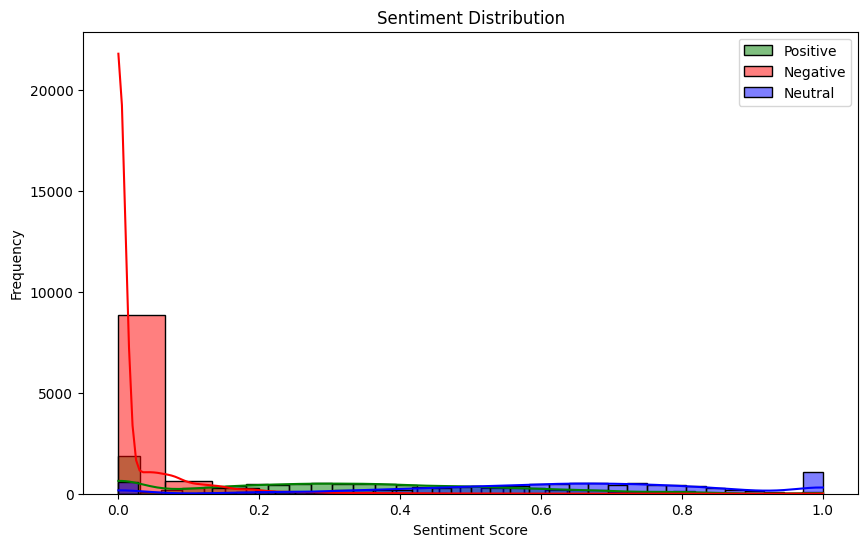

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the sentiment distributions
plt.figure(figsize=(10, 6))
sns.histplot(reviews_of_comments['positive'], kde=True, color='green', label='Positive')
sns.histplot(reviews_of_comments['negative'], kde=True, color='red', label='Negative')
sns.histplot(reviews_of_comments['neutral'], kde=True, color='blue', label='Neutral')

plt.legend()
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()